In [1]:
library(tidyverse)
library(data.table)
library(ggrepel)
#turning off warnings
options(warn=-1)
options(scipen = 999)
#setting plot width and height
options(repr.plot.width=15, repr.plot.height = 10)

na.omit.list <- function(y) { return(y[!sapply(y, function(x) all(is.na(x)))]) }

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




kpis: stickiness, speed, contested catch scenarios, break on ball
(scaled against overall xComp, just simple change in dist_rate_of_change???),
recovery speed (when x dist behind who gains), height, comp_prob[final] - comp_prob[first]
instead of identifying coverage, just ask, was he covering this guy?
take two or three key indicators of what you're looking at then regress them

In [2]:
comp_probs <- fread('../input/bdb-randomforest/comp_prob_dat.csv',
                   drop='V1')
head(comp_probs)
colnames(comp_probs)

gameId,playId,frameId,off_nflId,nflId,displayName,event,dist_from_off,dist_los,qb_s,⋯,distance_from_qb,receiver_distance_from_qb,ball_behind_db,diff_in_speed,diff_in_acceleration,diff_in_dir,his_off_most_open,receiver_behind_db,dist_rate_of_change,comp_prob
<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018090600,75,11,2533040,79848,Malcolm Jenkins,ball_snap,1.920339,1.22,0.00,⋯,10.23481,9.538433,0,0.01,0.01,258.48,0,1.89,0.000000000,0.7226427
2018090600,75,12,2533040,79848,Malcolm Jenkins,None,1.922134,1.22,0.00,⋯,10.24040,9.530519,0,0.01,0.01,276.29,0,1.89,0.000000000,0.7176427
2018090600,75,13,2533040,79848,Malcolm Jenkins,None,1.912302,1.22,0.03,⋯,10.24602,9.533651,0,-0.02,-0.29,280.46,0,1.88,0.000000000,0.7275392
2018090600,75,14,2533040,79848,Malcolm Jenkins,None,1.908743,1.22,0.22,⋯,10.23926,9.544658,0,-0.07,-0.50,34.84,0,1.88,-0.006038243,0.7558686
2018090600,75,15,2533040,79848,Malcolm Jenkins,None,1.889047,1.22,0.61,⋯,10.26599,9.563472,0,-0.22,-1.20,9.95,0,1.86,-0.017213601,0.6772426
2018090600,75,16,2533040,79848,Malcolm Jenkins,None,1.859516,1.22,1.18,⋯,10.31733,9.600417,0,-0.40,-1.57,29.29,0,1.83,-0.027603487,0.5723097


[1] "gameId"                    "playId"                   
 [3] "frameId"                   "off_nflId"                
 [5] "nflId"                     "displayName"              
 [7] "event"                     "dist_from_off"            
 [9] "dist_los"                  "qb_s"                     
[11] "qb_a"                      "max_space_available"      
[13] "distance_from_qb"          "receiver_distance_from_qb"
[15] "ball_behind_db"            "diff_in_speed"            
[17] "diff_in_acceleration"      "diff_in_dir"              
[19] "his_off_most_open"         "receiver_behind_db"       
[21] "dist_rate_of_change"       "comp_prob"

In [3]:
extra_dat <- fread('../input/coverage-id/extra_data.csv',
                  drop='V1')
head(extra_dat)
full_data <- left_join(comp_probs,
                      extra_dat,
                      by=c('gameId', 'playId', 'nflId'))
head(full_data)

gameId,playId,nflId,snap_to_throw,var_xs,var_ys,var_o,avg_speed,var_speed,look_at_qb,avg_dist,var_dist,avg_dir_diff,avg_speed_diff,pct_first_off,pct_last_off,last_off,first_off,var_look_at_qb,dist_los
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
2018090600,75,79848,2.5,1.70033046,0.22510538,5583.62867,1.871154,3.419619,0.6923077,2.038183,0.7144427,59.86346,-1.4450000,1.0000000,1.00000000,2533040,2533040,0.2215385,1.22
2018090600,75,2495613,2.5,0.10720446,1.20087646,333.14461,1.601923,1.279824,1.0000000,3.121003,1.8412830,96.86885,-1.6265385,0.9615385,0.03846154,2559033,2555415,0.0000000,3.64
2018090600,75,2534832,2.5,1.84011154,0.43926462,128.65881,1.780000,1.614448,1.0000000,17.105852,2.7880629,38.29346,-1.5361538,1.0000000,1.00000000,2533040,2533040,0.0000000,16.50
2018090600,75,2552689,2.5,0.97037538,0.02726846,13.05627,1.246154,1.052137,1.0000000,7.093199,2.6571374,14.50462,-1.9615385,1.0000000,1.00000000,2555415,2555415,0.0000000,7.48
2018090600,75,2555383,2.5,6.13310046,0.27971954,1496.27083,2.948077,4.262440,1.0000000,5.678933,2.0882765,27.34846,-1.1592308,1.0000000,1.00000000,2495454,2495454,0.0000000,6.19
2018090600,146,79848,2.0,0.01500143,2.61227476,139.61959,2.519048,2.972869,0.6666667,2.538371,1.1541539,150.75381,-0.4657143,0.8095238,0.19047619,2555415,2560854,0.2333333,2.62


gameId,playId,frameId,off_nflId,nflId,displayName,event,dist_from_off,dist_los.x,qb_s,⋯,avg_dist,var_dist,avg_dir_diff,avg_speed_diff,pct_first_off,pct_last_off,last_off,first_off,var_look_at_qb,dist_los.y
<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
2018090600,75,11,2533040,79848,Malcolm Jenkins,ball_snap,1.920339,1.22,0.00,⋯,2.038183,0.7144427,59.86346,-1.445,1,1,2533040,2533040,0.2215385,1.22
2018090600,75,12,2533040,79848,Malcolm Jenkins,None,1.922134,1.22,0.00,⋯,2.038183,0.7144427,59.86346,-1.445,1,1,2533040,2533040,0.2215385,1.22
2018090600,75,13,2533040,79848,Malcolm Jenkins,None,1.912302,1.22,0.03,⋯,2.038183,0.7144427,59.86346,-1.445,1,1,2533040,2533040,0.2215385,1.22
2018090600,75,14,2533040,79848,Malcolm Jenkins,None,1.908743,1.22,0.22,⋯,2.038183,0.7144427,59.86346,-1.445,1,1,2533040,2533040,0.2215385,1.22
2018090600,75,15,2533040,79848,Malcolm Jenkins,None,1.889047,1.22,0.61,⋯,2.038183,0.7144427,59.86346,-1.445,1,1,2533040,2533040,0.2215385,1.22
2018090600,75,16,2533040,79848,Malcolm Jenkins,None,1.859516,1.22,1.18,⋯,2.038183,0.7144427,59.86346,-1.445,1,1,2533040,2533040,0.2215385,1.22


In [4]:
plays <- fread('../input/nfl-big-data-bowl-2021/plays.csv')
plays <- plays %>%

select(gameId, playId, personnelD, passResult, epa)
head(plays)
colnames(plays)

gameId,playId,personnelD,passResult,epa
<int>,<int>,<chr>,<chr>,<dbl>
2018090600,75,"4 DL, 2 LB, 5 DB",C,0.2618273
2018090600,146,"4 DL, 2 LB, 5 DB",I,-0.3723598
2018090600,168,"4 DL, 2 LB, 5 DB",I,-0.7027787
2018090600,190,"4 DL, 1 LB, 6 DB",C,3.0475300
2018090600,256,"6 DL, 3 LB, 2 DB",I,-0.8422719
2018090600,320,"3 DL, 3 LB, 5 DB",C,-0.3440965


[1] "gameId"     "playId"     "personnelD" "passResult" "epa"

In [5]:
full_data <- left_join(full_data,
                      plays,
                      by=c('gameId', 'playId'))
full_data <- full_data %>%

mutate(complete = if_else(passResult == 'C', 1, 0))

In [6]:
# you want to only evaluate scenarios where you believe he's actually covering the guy he's nearest to
colnames(full_data)

[1] "gameId"                    "playId"                   
 [3] "frameId"                   "off_nflId"                
 [5] "nflId"                     "displayName"              
 [7] "event"                     "dist_from_off"            
 [9] "dist_los.x"                "qb_s"                     
[11] "qb_a"                      "max_space_available"      
[13] "distance_from_qb"          "receiver_distance_from_qb"
[15] "ball_behind_db"            "diff_in_speed"            
[17] "diff_in_acceleration"      "diff_in_dir"              
[19] "his_off_most_open"         "receiver_behind_db"       
[21] "dist_rate_of_change"       "comp_prob"                
[23] "snap_to_throw"             "var_xs"                   
[25] "var_ys"                    "var_o"                    
[27] "avg_speed"                 "var_speed"                
[29] "look_at_qb"                "avg_dist"                 
[31] "var_dist"                  "avg_dir_diff"             
[33] "avg_speed_diff"            "pct_first_off"            
[35] "pct_last_off"              "last_off"                 
[37] "first_off"                 "var_look_at_qb"           
[39] "dist_los.y"                "personnelD"               
[41] "passResult"                "epa"                      
[43] "complete"

In [7]:
target_dat <- fread('../input/merge-clean-data/full_tracking_df.csv',
                   drop='V1')
target_dat <- target_dat %>%

select(gameId, playId, targetNflId)

target_dat <- unique(target_dat)
head(target_dat)

gameId,playId,targetNflId
<int>,<int>,<int>
2018090600,75,2495454
2018090600,146,2560854
2018090600,168,2543583
2018090600,190,2495454
2018090600,256,2543583
2018090600,320,2552600


In [8]:
full_data <- left_join(full_data,
                      target_dat,
                      by=c('gameId', 'playId'))
head(full_data)

gameId,playId,frameId,off_nflId,nflId,displayName,event,dist_from_off,dist_los.x,qb_s,⋯,pct_last_off,last_off,first_off,var_look_at_qb,dist_los.y,personnelD,passResult,epa,complete,targetNflId
<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
2018090600,75,11,2533040,79848,Malcolm Jenkins,ball_snap,1.920339,1.22,0.00,⋯,1,2533040,2533040,0.2215385,1.22,"4 DL, 2 LB, 5 DB",C,0.2618273,1,2495454
2018090600,75,12,2533040,79848,Malcolm Jenkins,None,1.922134,1.22,0.00,⋯,1,2533040,2533040,0.2215385,1.22,"4 DL, 2 LB, 5 DB",C,0.2618273,1,2495454
2018090600,75,13,2533040,79848,Malcolm Jenkins,None,1.912302,1.22,0.03,⋯,1,2533040,2533040,0.2215385,1.22,"4 DL, 2 LB, 5 DB",C,0.2618273,1,2495454
2018090600,75,14,2533040,79848,Malcolm Jenkins,None,1.908743,1.22,0.22,⋯,1,2533040,2533040,0.2215385,1.22,"4 DL, 2 LB, 5 DB",C,0.2618273,1,2495454
2018090600,75,15,2533040,79848,Malcolm Jenkins,None,1.889047,1.22,0.61,⋯,1,2533040,2533040,0.2215385,1.22,"4 DL, 2 LB, 5 DB",C,0.2618273,1,2495454
2018090600,75,16,2533040,79848,Malcolm Jenkins,None,1.859516,1.22,1.18,⋯,1,2533040,2533040,0.2215385,1.22,"4 DL, 2 LB, 5 DB",C,0.2618273,1,2495454


In [9]:
full_data <- full_data %>%

filter(snap_to_throw >= 1.5)

In [10]:
colnames(full_data)

[1] "gameId"                    "playId"                   
 [3] "frameId"                   "off_nflId"                
 [5] "nflId"                     "displayName"              
 [7] "event"                     "dist_from_off"            
 [9] "dist_los.x"                "qb_s"                     
[11] "qb_a"                      "max_space_available"      
[13] "distance_from_qb"          "receiver_distance_from_qb"
[15] "ball_behind_db"            "diff_in_speed"            
[17] "diff_in_acceleration"      "diff_in_dir"              
[19] "his_off_most_open"         "receiver_behind_db"       
[21] "dist_rate_of_change"       "comp_prob"                
[23] "snap_to_throw"             "var_xs"                   
[25] "var_ys"                    "var_o"                    
[27] "avg_speed"                 "var_speed"                
[29] "look_at_qb"                "avg_dist"                 
[31] "var_dist"                  "avg_dir_diff"             
[33] "avg_speed_diff"            "pct_first_off"            
[35] "pct_last_off"              "last_off"                 
[37] "first_off"                 "var_look_at_qb"           
[39] "dist_los.y"                "personnelD"               
[41] "passResult"                "epa"                      
[43] "complete"                  "targetNflId"

In [11]:
full_data <- full_data %>%

mutate(covering_target = if_else(last_off == targetNflId & pct_last_off > .333, 1, 0),
      complete_covering_target = if_else(covering_target == 1 & complete == 1, 1, 0))

In [12]:
library(ggtext)
library(ggforce) 
library(ggridges)
library(ggrepel) 
library(ggbeeswarm) 
library(extrafont) 

Registering fonts with R



In [13]:
butler_sum_1 <- full_data %>%

filter(displayName == 'Malcolm Butler' & gameId == 2018091607 & playId == 3307)
write.csv(butler_sum_1, 'butler_sum_1.csv')

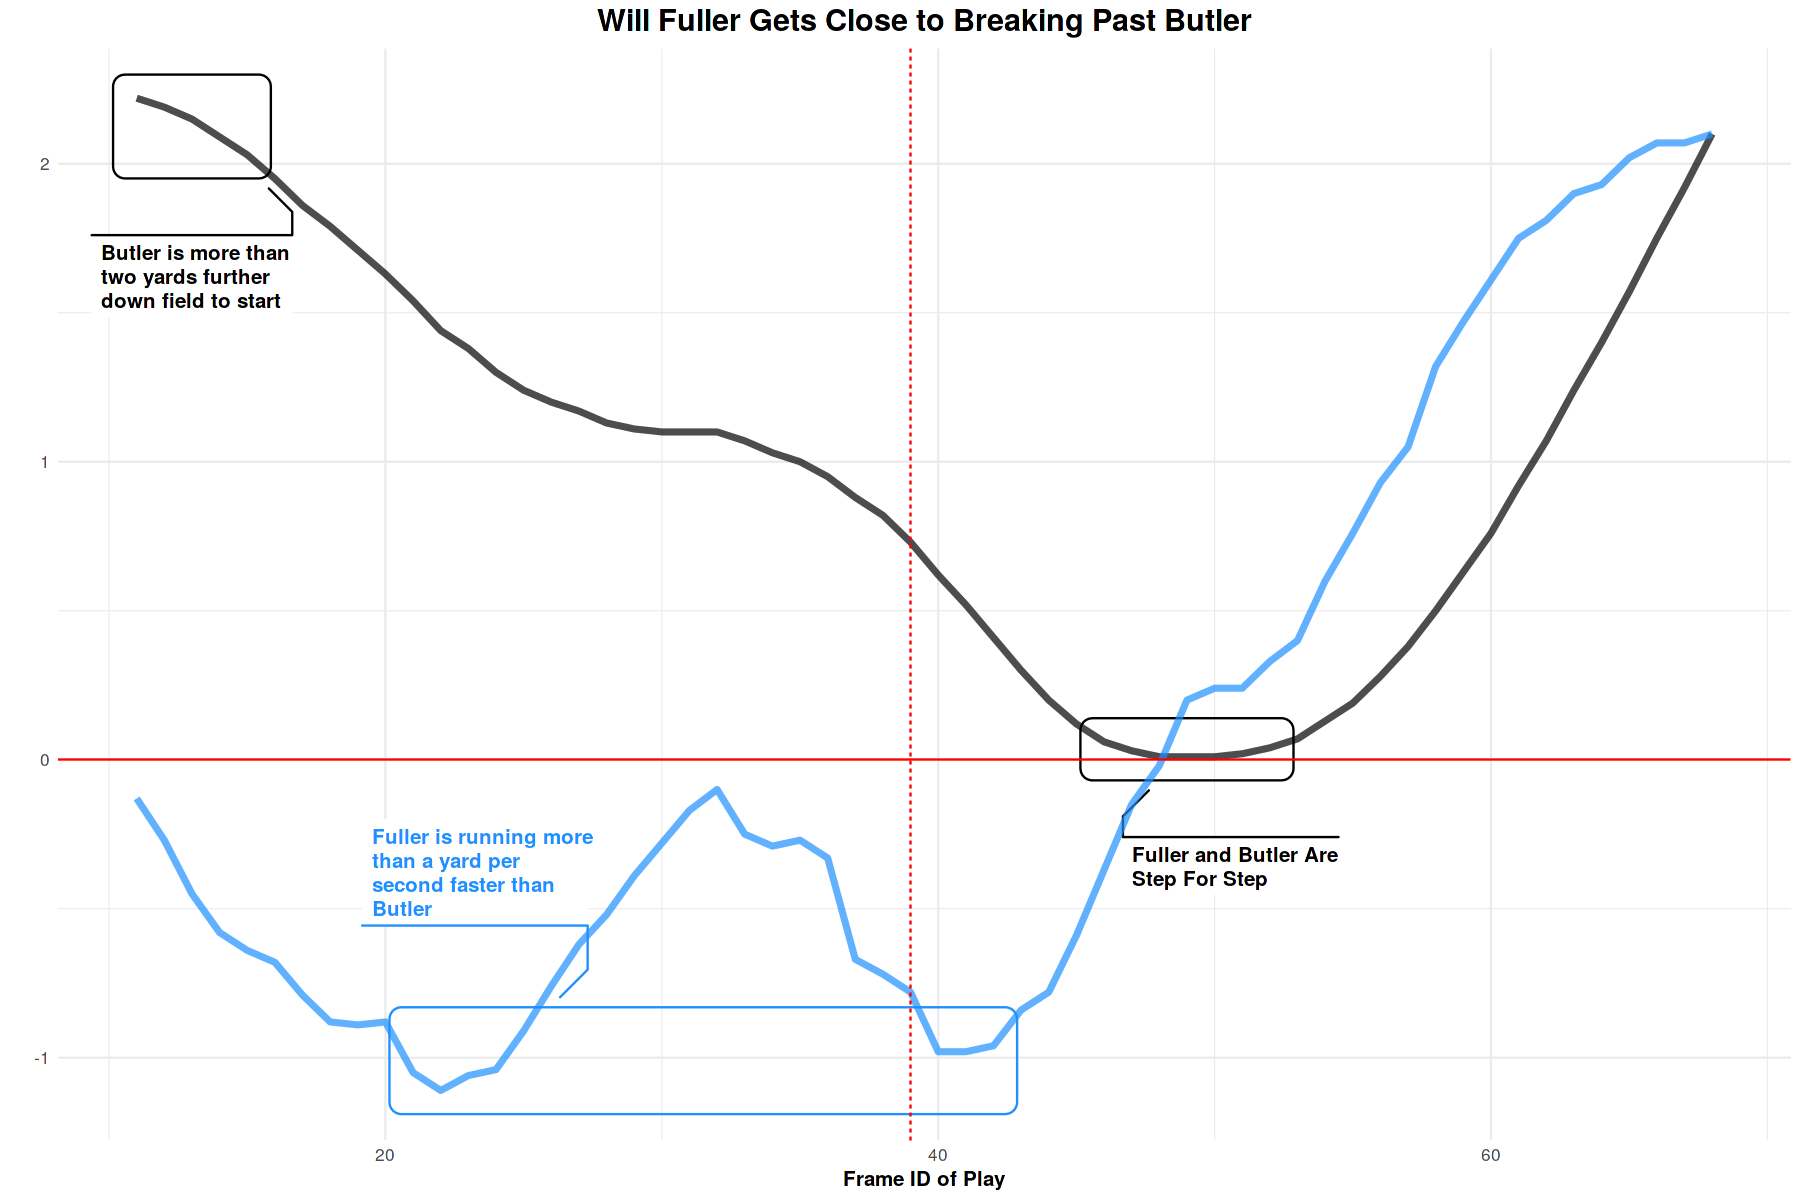

In [14]:
butler_sum_1 %>%

ggplot(aes(x=frameId)) +
geom_line(aes(y=receiver_behind_db), size=1.5, alpha=.7) +
geom_mark_rect(aes(y=receiver_behind_db,
                   filter = frameId %in% seq(46, 52),
                   description = 'Fuller and Butler Are Step For Step'),
               color = "black", label.fontface = "bold", label.colour = "black", con.colour = "black") +
geom_mark_rect(aes(y=receiver_behind_db,
                   filter = receiver_behind_db > 2 & frameId < 50,
                   description = 'Butler is more than two yards further down field to start'),
               color = "black", label.fontface = "bold", label.colour = "black", con.colour = "black") +
geom_line(aes(y=diff_in_speed), col='dodgerblue', size=1.5, alpha=.7) +
geom_mark_rect(aes(y=diff_in_speed,
                   filter = diff_in_speed < -.9,
                   description = 'Fuller is running more than a yard per second faster than Butler'),
               color = "dodgerblue", label.fontface = "bold", label.colour = "dodgerblue", con.colour = "dodgerblue") +
labs(title = "Will Fuller Gets Close to Breaking Past Butler",
    x='Frame ID of Play',
    y="") +
geom_hline(yintercept = 0, col='red') +
geom_vline(xintercept = butler_sum_1$frameId[which(butler_sum_1$event == 'pass_forward')], linetype='dashed', col='red') +
theme_minimal() +
theme(
    axis.title = element_text(size = 12, face='bold'),
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 12),
    legend.position = 'none'
  )

So, what we see here is Butler is able to pick up speed at a rate where he's able to run stride for stride with Fuller, despite the total space decreasing. Butler never lets Fuller pass him which ensures completion probability does not go above 50%.

In [15]:
cover_tar <- full_data %>%

filter(covering_target == 1) %>%

select(gameId, playId, nflId, comp_prob, displayName, complete_covering_target, event, dist_los.y, look_at_qb, dist_from_off) %>%

group_split(gameId, playId, nflId)
# grab the comp_prob at different points in time from here ... come aggregate comp probs and observed
# and specialized time from this area
sample <- cover_tar[[1]]
sample

gameId,playId,nflId,comp_prob,displayName,complete_covering_target,event,dist_los.y,look_at_qb,dist_from_off
<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2018090600,75,2555383,0.8169872,Jalen Mills,1,ball_snap,6.19,1,7.472858
2018090600,75,2555383,0.8169872,Jalen Mills,1,None,6.19,1,7.473801
2018090600,75,2555383,0.8611538,Jalen Mills,1,None,6.19,1,7.442990
2018090600,75,2555383,0.8598819,Jalen Mills,1,None,6.19,1,7.423079
2018090600,75,2555383,0.8921941,Jalen Mills,1,None,6.19,1,7.402229
2018090600,75,2555383,0.8892845,Jalen Mills,1,None,6.19,1,7.350599
2018090600,75,2555383,0.8608454,Jalen Mills,1,None,6.19,1,7.259160
2018090600,75,2555383,0.8941784,Jalen Mills,1,None,6.19,1,7.106230
2018090600,75,2555383,0.8646456,Jalen Mills,1,None,6.19,1,6.901949


In [16]:
covering_target_summary <- function(player_df){
    displayName = player_df$displayName[1]
    gameId = player_df$gameId[1]
    playId = player_df$playId[1]
    nflId = player_df$nflId[1]
    # change index to compensate for knowledge within predicting on training data
    ind_pf <- which(player_df$event == 'pass_forward') - 1
    
    if(length(ind_pf) == 0){
        return(NA)
    }
    
    avg_comp_prob_ct <- mean(player_df$comp_prob, na.rm=TRUE)
    var_comp_prob_ct <- var(player_df$comp_prob, na.rm=TRUE)
    
    forward_gain = player_df$comp_prob[ind_pf] - player_df$comp_prob[length(player_df$comp_prob)]
    # regress forward gain by pass_forward_cp to find who outperforms and gains ground well
    pass_forward_cp = player_df$comp_prob[ind_pf]
    pass_arrive_cp = player_df$comp_prob[length(player_df$comp_prob)]
    
    cp_pre_pf <- mean(player_df$comp_prob[1:ind_pf])
    cp_post_pf <- mean(player_df$comp_prob[(ind_pf+2):length(player_df$comp_prob)])
    
    pass_outcome <- player_df$complete_covering_target[1]
    
    return(data.frame(displayName, gameId, playId, nflId, avg_comp_prob_ct, var_comp_prob_ct, pass_outcome,
                      forward_gain, pass_forward_cp, pass_arrive_cp, cp_pre_pf, cp_post_pf))
}
covering_target_summary(sample)

displayName,gameId,playId,nflId,avg_comp_prob_ct,var_comp_prob_ct,pass_outcome,forward_gain,pass_forward_cp,pass_arrive_cp,cp_pre_pf,cp_post_pf
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jalen Mills,2018090600,75,2555383,0.7599375,0.00722284,1,0.02717081,0.7295809,0.7024101,0.7577168,0.7596471


In [17]:
ct_summary <- bind_rows(na.omit.list(lapply(cover_tar, covering_target_summary)))
ct_summary

displayName,gameId,playId,nflId,avg_comp_prob_ct,var_comp_prob_ct,pass_outcome,forward_gain,pass_forward_cp,pass_arrive_cp,cp_pre_pf,cp_post_pf
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jalen Mills,2018090600,75,2555383,0.7599375,0.007222840,1,0.027170810,0.7295809,0.7024101,0.7577168,0.7596471
Jalen Mills,2018090600,146,2555383,0.7665860,0.017808924,0,0.197650022,0.7453697,0.5477196,0.8317970,0.5801613
Malcolm Jenkins,2018090600,190,79848,0.7098040,0.024670452,1,-0.236996444,0.6420042,0.8790006,0.6344188,0.8331255
Corey Graham,2018090600,190,2495613,0.5490562,0.020014018,1,0.193692602,0.4995641,0.3058714,0.6394140,0.4057183
Sidney Jones,2018090600,190,2557958,0.6565908,0.015483580,1,0.289609390,0.7534848,0.4638754,0.7375363,0.5173402
Robert Alford,2018090600,320,2539653,0.6698219,0.014339700,1,0.315858767,0.7546359,0.4387771,0.7279522,0.5174054
Ricardo Allen,2018090600,344,2543850,0.5943162,0.054219448,0,-0.277024744,0.3264335,0.6034583,0.7186495,0.3449529
Ronald Darby,2018090600,402,2552689,0.6562086,0.022995405,0,0.239615007,0.5524425,0.3128275,0.7054441,0.5376013
Ronald Darby,2018090600,636,2552689,0.4088780,0.008712596,0,-0.168071435,0.3385831,0.5066546,0.4218271,0.3960773


In [18]:
ct_full <- ct_summary %>%

group_by(displayName, nflId) %>%

summarise(num_snaps_ct = n(),
         avg_comp_prob_ct = mean(avg_comp_prob_ct),
          var_comp_prob_ct = mean(var_comp_prob_ct),
         avg_ob_comp_pct = mean(pass_outcome),
         avg_gain = mean(forward_gain),
         avg_pf_cp = mean(pass_forward_cp),
         avg_pa_cp = mean(pass_arrive_cp)) %>%

filter(num_snaps_ct > 60) %>%

mutate(diff_ct = avg_comp_prob_ct - avg_ob_comp_pct) %>%

arrange(avg_comp_prob_ct)

write.csv(ct_full, 'ct_agg.csv')

head(ct_full)

`summarise()` regrouping output by 'displayName' (override with `.groups` argument)



displayName,nflId,num_snaps_ct,avg_comp_prob_ct,var_comp_prob_ct,avg_ob_comp_pct,avg_gain,avg_pf_cp,avg_pa_cp,diff_ct
<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Byron Jones,2552568,77,0.5408802,0.02515372,0.5194805,0.08049465,0.5085155,0.4280208,0.02139967
Jaire Alexander,2560952,73,0.5413108,0.02933297,0.4794521,0.10878211,0.4897671,0.3809850,0.06185876
Steven Nelson,2552265,97,0.5426131,0.02285516,0.4639175,0.06807492,0.5012180,0.4331431,0.07869558
Nevin Lawson,2543872,63,0.5444689,0.02257047,0.4603175,0.06825538,0.5242926,0.4560372,0.08415145
Kendall Fuller,2555349,77,0.5451656,0.02679923,0.4675325,0.09042501,0.4873384,0.3969133,0.07763310
Orlando Scandrick,2307,83,0.5528164,0.02443303,0.4939759,0.05983625,0.5104598,0.4506235,0.05884046


`geom_smooth()` using formula 'y ~ x'



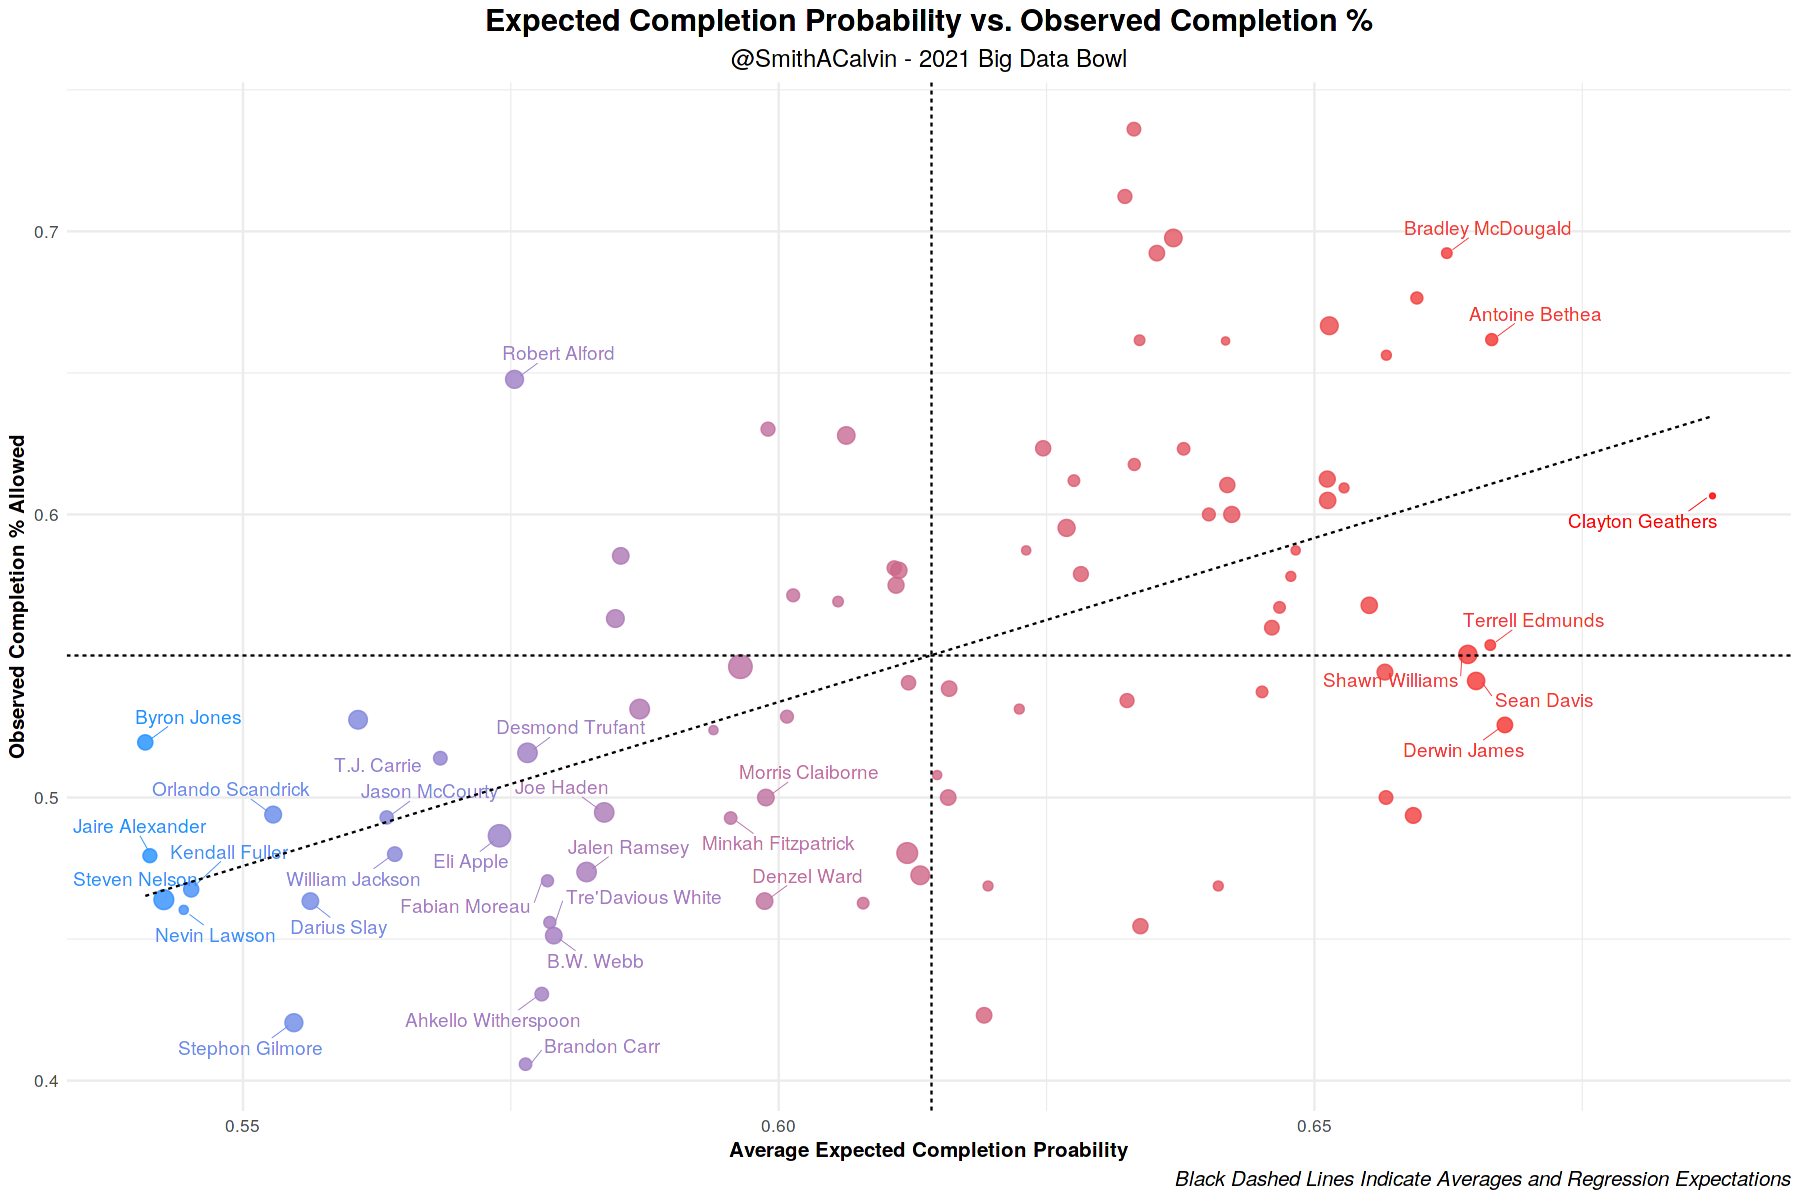

In [19]:
ct_full %>%

ggplot(aes(x=avg_comp_prob_ct, y=avg_ob_comp_pct, col=avg_comp_prob_ct)) +
geom_point(aes(size = num_snaps_ct), alpha = 0.8) +
geom_text_repel(data = filter(ct_full, (avg_comp_prob_ct < .6 & avg_ob_comp_pct < .52) |
                             avg_comp_prob_ct > .66 | (avg_comp_prob_ct < .6 & avg_ob_comp_pct > .645)),
                aes(label = displayName), force = 1, point.padding = 0.5,
                segment.size = 0.2) + 
theme_minimal() +
geom_vline(xintercept = mean(ct_full$avg_comp_prob_ct), col='black', linetype='dashed') +
geom_hline(yintercept = mean(ct_full$avg_ob_comp_pct), col='black', linetype='dashed') +
geom_smooth(method='lm', col='black', se=FALSE, linetype='dashed', size=.5) +
scale_color_gradient(low='dodgerblue', high='red') +
labs(title = 'Expected Completion Probability vs. Observed Completion %',
    subtitle = '@SmithACalvin - 2021 Big Data Bowl',
    x = 'Average Expected Completion Proability',
    y = 'Observed Completion % Allowed',
    caption = 'Black Dashed Lines Indicate Averages and Regression Expectations') +
theme(
    axis.title = element_text(size = 12, face='bold'),
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 12, face='italic'),
    legend.position = 'none'
  )

In [20]:
gain_lm <- lm(forward_gain ~ pass_forward_cp, data = ct_summary)
summary(gain_lm)


Call:
lm(formula = forward_gain ~ pass_forward_cp, data = ct_summary)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52679 -0.11393  0.00823  0.11407  0.46597 

Coefficients:
                 Estimate Std. Error t value            Pr(>|t|)    
(Intercept)     -0.200148   0.003985  -50.23 <0.0000000000000002 ***
pass_forward_cp  0.490682   0.006411   76.54 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1477 on 12927 degrees of freedom
Multiple R-squared:  0.3119,	Adjusted R-squared:  0.3118 
F-statistic:  5859 on 1 and 12927 DF,  p-value: < 0.00000000000000022


`geom_smooth()` using formula 'y ~ x'



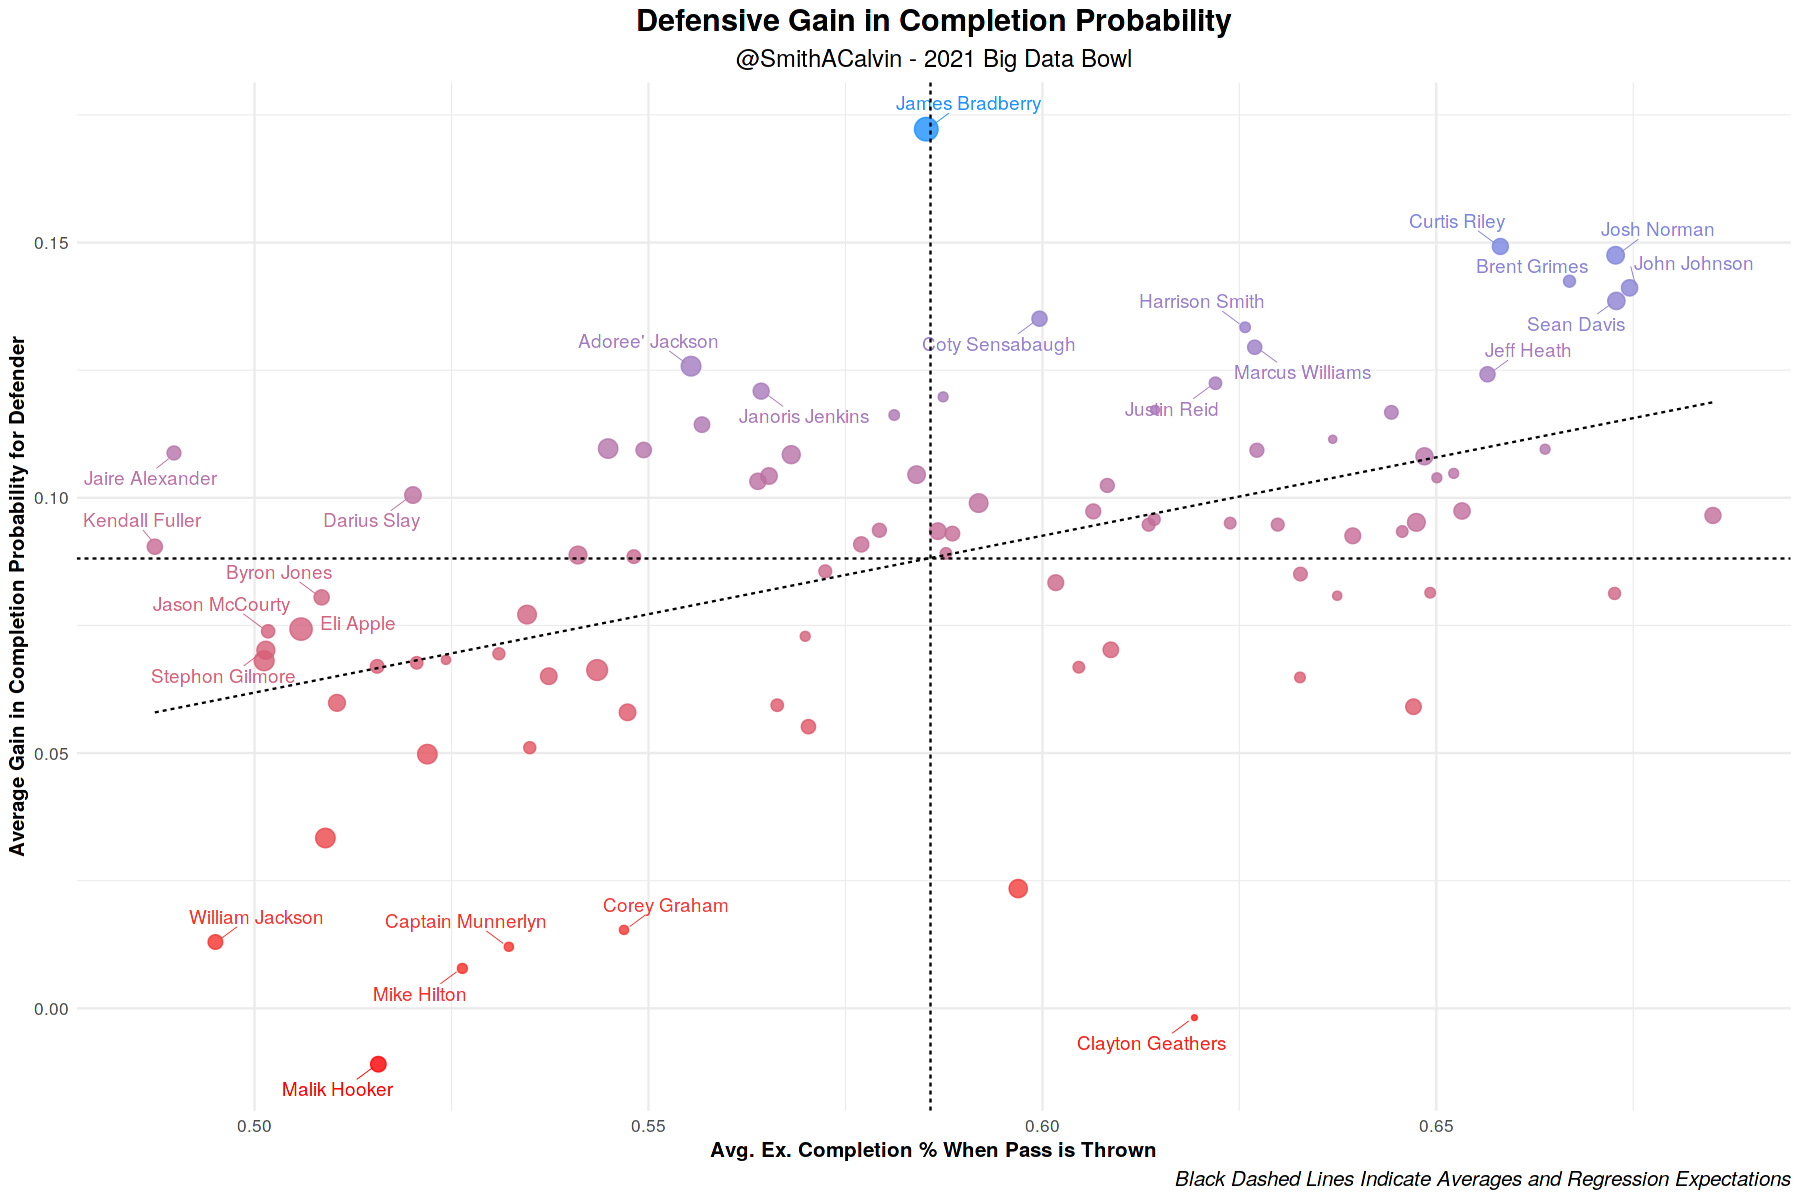

In [21]:
ct_full %>%

ggplot(aes(x=avg_pf_cp, y=avg_gain, col=avg_gain)) +
geom_point(aes(size = num_snaps_ct), alpha = 0.8) +
geom_text_repel(data = filter(ct_full, (avg_pf_cp < .53 & avg_gain > .07) |
                             avg_gain < .02 | avg_gain > .12),
                aes(label = displayName), force = 1, point.padding = 0.5,
                segment.size = 0.2) + 
theme_minimal() +
geom_vline(xintercept = mean(ct_full$avg_pf_cp), col='black', linetype='dashed') +
geom_hline(yintercept = mean(ct_full$avg_gain), col='black', linetype='dashed') +
geom_smooth(method='lm', col='black', se=FALSE, linetype='dashed', size=.5) +
scale_color_gradient(low='red', high='dodgerblue') +
labs(title = 'Defensive Gain in Completion Probability',
    subtitle = '@SmithACalvin - 2021 Big Data Bowl',
    x = 'Avg. Ex. Completion % When Pass is Thrown',
    y = 'Average Gain in Completion Probability for Defender',
    caption = 'Black Dashed Lines Indicate Averages and Regression Expectations') +
theme(
    axis.title = element_text(size = 12, face='bold'),
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 18, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    plot.caption = element_text(size = 12, face='italic'),
    legend.position = 'none'
  )

In [22]:
plays_players <- full_data %>%

select(gameId, playId, frameId, nflId, comp_prob, displayName, dist_los.y, look_at_qb, dist_from_off) %>%

group_split(gameId, playId, nflId)

In [23]:
sample <- plays_players[[1]]
sample
# BEFORE YOU MOVE ON YOU MUST DETERMINE THE OBSERVED COMPLETION %
# cant assign a 1 to jenkins when he never covered the guy
# so, you can compare the overall xComp, the xComp on being targeted vs non-targeted,
# xComp on targets less observed comp %

gameId,playId,frameId,nflId,comp_prob,displayName,dist_los.y,look_at_qb,dist_from_off
<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2018090600,75,11,79848,0.7226427,Malcolm Jenkins,1.22,0.6923077,1.920339
2018090600,75,12,79848,0.7176427,Malcolm Jenkins,1.22,0.6923077,1.922134
2018090600,75,13,79848,0.7275392,Malcolm Jenkins,1.22,0.6923077,1.912302
2018090600,75,14,79848,0.7558686,Malcolm Jenkins,1.22,0.6923077,1.908743
2018090600,75,15,79848,0.6772426,Malcolm Jenkins,1.22,0.6923077,1.889047
2018090600,75,16,79848,0.5723097,Malcolm Jenkins,1.22,0.6923077,1.859516
2018090600,75,17,79848,0.5697108,Malcolm Jenkins,1.22,0.6923077,1.792540
2018090600,75,18,79848,0.5660833,Malcolm Jenkins,1.22,0.6923077,1.698588
2018090600,75,19,79848,0.5486494,Malcolm Jenkins,1.22,0.6923077,1.603309


In [24]:
get_avg_plays <- function(player_df){
    displayName = player_df$displayName[1]
    gameId = player_df$gameId[1]
    playId = player_df$playId[1]
    nflId = player_df$nflId[1]
    
    avg_comp_prob = mean(player_df$comp_prob)
    var_comp_prob = var(player_df$comp_prob)
    dist_los = player_df$dist_los.y[1]
    look_at_qb = player_df$look_at_qb[1]
    dist_from_off = player_df$dist_from_off[1]
    return(data.frame(displayName, gameId, playId, nflId, avg_comp_prob, var_comp_prob,
                     dist_los, look_at_qb, dist_from_off))
}
get_avg_plays(sample)

displayName,gameId,playId,nflId,avg_comp_prob,var_comp_prob,dist_los,look_at_qb,dist_from_off
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Malcolm Jenkins,2018090600,75,79848,0.6377077,0.01212655,1.22,0.6923077,1.920339


In [25]:
avg_comp_probs <- bind_rows(lapply(plays_players, get_avg_plays))
avg_comp_probs
# how can i account for when guys had to cover for longer

displayName,gameId,playId,nflId,avg_comp_prob,var_comp_prob,dist_los,look_at_qb,dist_from_off
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Malcolm Jenkins,2018090600,75,79848,0.6377077,0.0121265533,1.22,0.69230769,1.920339
Corey Graham,2018090600,75,2495613,0.6818201,0.0189930263,3.64,1.00000000,4.833353
Rodney McLeod,2018090600,75,2534832,0.6656497,0.0040755452,16.50,1.00000000,18.720590
Ronald Darby,2018090600,75,2552689,0.7020698,0.0195913235,7.48,1.00000000,8.774474
Jalen Mills,2018090600,75,2555383,0.7599375,0.0072228404,6.19,1.00000000,7.472858
Malcolm Jenkins,2018090600,146,79848,0.6016195,0.0170683844,2.62,0.66666667,4.016329
Rodney McLeod,2018090600,146,2534832,0.6515882,0.0035075320,15.80,1.00000000,17.777258
Ronald Darby,2018090600,146,2552689,0.7374975,0.0066395605,7.50,1.00000000,8.282041
Jalen Mills,2018090600,146,2555383,0.7665860,0.0178089238,7.56,1.00000000,8.657858


In [26]:
summary <- avg_comp_probs %>%

group_by(nflId, displayName) %>%

summarise(avg_comp_prob = mean(avg_comp_prob),
         num_plays = n()) %>%

filter(num_plays > 200) %>%

arrange(avg_comp_prob)
head(summary)
write.csv(summary, 'all_plays.csv')

`summarise()` regrouping output by 'nflId' (override with `.groups` argument)



nflId,displayName,avg_comp_prob,num_plays
<dbl>,<fct>,<dbl>,<int>
2552568,Byron Jones,0.5682150,521
2539653,Robert Alford,0.5693786,495
2307,Orlando Scandrick,0.5716953,430
2543872,Nevin Lawson,0.5745061,427
2558062,Gareon Conley,0.5745755,302
2556367,William Jackson,0.5749451,527


In [27]:
comp_ct_overall <- merge(summary,
                        ct_full,
                        on=c('nflId', 'displayName'))
head(comp_ct_overall)
write.csv(comp_ct_overall, 'comp_ct_overall.csv')

,nflId,displayName,avg_comp_prob,num_plays,num_snaps_ct,avg_comp_prob_ct,var_comp_prob_ct,avg_ob_comp_pct,avg_gain,avg_pf_cp,avg_pa_cp,diff_ct
,<dbl>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2307,Orlando Scandrick,0.5716953,430,83,0.5528164,0.02443303,0.4939759,0.05983625,0.5104598,0.4506235,0.058840456
2,2495108,Prince Amukamara,0.5772151,515,91,0.5607411,0.02451816,0.5274725,0.07712644,0.5345865,0.4574600,0.033268527
3,2495153,Marcus Gilchrist,0.6362082,400,76,0.6282065,0.01739303,0.5789474,0.09733574,0.6064592,0.5091234,0.049259132
4,2495613,Corey Graham,0.6197239,383,63,0.6147910,0.01272590,0.5079365,0.01535968,0.5468900,0.5315303,0.106854477
5,2495807,Antoine Bethea,0.6628322,473,68,0.6665501,0.01322941,0.6617647,0.08126327,0.6726276,0.5913644,0.004785348
6,2495872,Johnathan Joseph,0.6262123,412,78,0.6158208,0.02793654,0.5000000,0.11432869,0.5567906,0.4424620,0.115820826


In [28]:
comp_pct_lm <- lm(avg_comp_prob ~ avg_comp_prob_ct, data = comp_ct_overall)
summary(comp_pct_lm)


Call:
lm(formula = avg_comp_prob ~ avg_comp_prob_ct, data = comp_ct_overall)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.026573 -0.006452 -0.000909  0.006794  0.037437 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)       0.22507    0.02297   9.798  0.00000000000000105 ***
avg_comp_prob_ct  0.64462    0.03733  17.266 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01268 on 87 degrees of freedom
Multiple R-squared:  0.7741,	Adjusted R-squared:  0.7715 
F-statistic: 298.1 on 1 and 87 DF,  p-value: < 0.00000000000000022


In [29]:
library(plotly)
library(htmlwidgets)
library(IRdisplay)
dir.create(file.path("plots/"), showWarnings = FALSE)
p <- comp_ct_overall %>%

ggplot(aes(x=avg_comp_prob_ct, y=avg_comp_prob, col=avg_comp_prob_ct, text=displayName)) +
geom_point(aes(size = num_snaps_ct), alpha = 0.8) +
stat_smooth(method='lm', col='black', se=FALSE, linetype='dashed', size=.5) +
# geom_text_repel(data = filter(comp_ct_overall, (avg_comp_prob_ct < .6 & avg_comp_prob < .6) |
#                              avg_comp_prob > .66),
#                 aes(label = displayName), force = 1, point.padding = 0.5,
#                 segment.size = 0.2) + 
theme_minimal() +
# geom_vline(xintercept = mean(ct_full$avg_comp_prob_ct), col='black', linetype='dashed') +
# geom_hline(yintercept = mean(ct_full$avg_comp_prob), col='black', linetype='dashed') +
scale_color_gradient(low='dodgerblue', high='red') +
labs(title = 'Expected Completion Probability While Covering the Target vs. Overall Expected Completion Probability',
    subtitle = '@SmithACalvin - 2021 Big Data Bowl',
    x = 'Average Expected Completion Proability (Covering Target)',
    y = 'Average Expected Completion Probability',
    caption = 'Black Dashed Lines Indicate Averages and Regression Expectations') +
theme(
    axis.title = element_text(size = 10, face='bold'),
    axis.text = element_text(size = 8),
    plot.title = element_text(size = 14, hjust = 0.5, face='bold'),
    plot.subtitle = element_text(size = 12, hjust = 0.5),
    plot.caption = element_text(size = 10, face='italic'),
    legend.position = 'none'
  )
p <- ggplotly(p, tooltip='text')

f <-"plots/plot2.html"
saveWidget(p, file.path(normalizePath(dirname(f)),basename(f)))
display_html('<iframe src="plots/plot2.html" align="center" width="100%" height="500" frameBorder="0"></iframe>')


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


The following object is masked from ‘package:httr’:

    config


`geom_smooth()` using formula 'y ~ x'



In [30]:
head(avg_comp_probs)
press_coverage <- avg_comp_probs %>%

filter(look_at_qb < 1 & dist_los < 2 & dist_from_off < 2) %>%

group_by(displayName, nflId) %>%

summarise(avg_comp_prob_jam = mean(avg_comp_prob),
         num_jam_snaps = n()) %>%

filter(num_jam_snaps > 6) %>%

arrange(avg_comp_prob_jam)

head(press_coverage)

,displayName,gameId,playId,nflId,avg_comp_prob,var_comp_prob,dist_los,look_at_qb,dist_from_off
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Malcolm Jenkins,2018090600,75,79848,0.6377077,0.012126553,1.22,0.6923077,1.920339
2,Corey Graham,2018090600,75,2495613,0.6818201,0.018993026,3.64,1.0000000,4.833353
3,Rodney McLeod,2018090600,75,2534832,0.6656497,0.004075545,16.50,1.0000000,18.720590
4,Ronald Darby,2018090600,75,2552689,0.7020698,0.019591324,7.48,1.0000000,8.774474
5,Jalen Mills,2018090600,75,2555383,0.7599375,0.007222840,6.19,1.0000000,7.472858
6,Malcolm Jenkins,2018090600,146,79848,0.6016195,0.017068384,2.62,0.6666667,4.016329


`summarise()` regrouping output by 'displayName' (override with `.groups` argument)



displayName,nflId,avg_comp_prob_jam,num_jam_snaps
<fct>,<dbl>,<dbl>,<int>
Tony Brown,2560982,0.4407797,13
Mike Ford,2561527,0.4429339,8
Morgan Burnett,496727,0.4431961,9
Charvarius Ward,2561417,0.4512734,8
Morris Claiborne,2533059,0.4583577,15
Vonn Bell,2555530,0.4585520,17


In [31]:
comp_ct_overall <- left_join(comp_ct_overall,
                            press_coverage,
                            by=c('nflId', 'displayName'))
head(comp_ct_overall)

,nflId,displayName,avg_comp_prob,num_plays,num_snaps_ct,avg_comp_prob_ct,var_comp_prob_ct,avg_ob_comp_pct,avg_gain,avg_pf_cp,avg_pa_cp,diff_ct,avg_comp_prob_jam,num_jam_snaps
,<dbl>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2307,Orlando Scandrick,0.5716953,430,83,0.5528164,0.02443303,0.4939759,0.05983625,0.5104598,0.4506235,0.058840456,0.5014432,58
2,2495108,Prince Amukamara,0.5772151,515,91,0.5607411,0.02451816,0.5274725,0.07712644,0.5345865,0.4574600,0.033268527,0.5155586,58
3,2495153,Marcus Gilchrist,0.6362082,400,76,0.6282065,0.01739303,0.5789474,0.09733574,0.6064592,0.5091234,0.049259132,NA,NA
4,2495613,Corey Graham,0.6197239,383,63,0.6147910,0.01272590,0.5079365,0.01535968,0.5468900,0.5315303,0.106854477,NA,NA
5,2495807,Antoine Bethea,0.6628322,473,68,0.6665501,0.01322941,0.6617647,0.08126327,0.6726276,0.5913644,0.004785348,NA,NA
6,2495872,Johnathan Joseph,0.6262123,412,78,0.6158208,0.02793654,0.5000000,0.11432869,0.5567906,0.4424620,0.115820826,NA,NA


In [32]:
table <- comp_ct_overall %>%

select(displayName, avg_comp_prob, avg_comp_prob_ct, avg_ob_comp_pct, avg_pa_cp, avg_gain, avg_comp_prob_jam) %>%

arrange(avg_comp_prob_ct)
colnames(table) <- c('Name', 'Avg. xComp', 'Avg. xComp (Covering Target)', 'Comp. % Allowed',
                    'Avg. xComp When Pass Arrives', 'Avg. Gain in xComp from Pass Throw to Arrival',
                    'Avg. xComp In Press')
table <- cbind.data.frame(table[1], round(table[2:length(table)], 3))
write.csv(table, 'table.csv')

In [33]:
library(DT)
library(htmlwidgets)
library(IRdisplay)

dir.create(file.path("plots/"), showWarnings = FALSE)

set.seed(1234)
t <- datatable(table, rownames=FALSE,
              filter = 'top', options = list(pageLength = 5, autoWidth = TRUE,
                                            initComplete = JS("function(settings, json) {",
                                                              "$(this.api().table().header()).css({'background-color': 'lightgray', 'color': 'black'});",
                                                              "}"))) %>%
  formatStyle(
    'Avg. xComp',
     background = styleColorBar(table$`Avg. xComp`, 'lightyellow'),
     backgroundSize = '98% 88%',
     backgroundRepeat = 'no-repeat',
     backgroundPosition = 'center'
  ) %>%
  formatStyle(
    'Avg. xComp (Covering Target)',
     background = styleColorBar(table$`Avg. xComp (Covering Target)`, 'lightgreen'),
     backgroundSize = '98% 88%',
     backgroundRepeat = 'no-repeat',
     backgroundPosition = 'center'
  ) %>%
  formatStyle(
    'Comp. % Allowed',
     background = styleColorBar(table$`Comp. % Allowed`, 'lightgreen'),
     backgroundSize = '98% 88%',
     backgroundRepeat = 'no-repeat',
     backgroundPosition = 'center'
  ) %>%
  formatStyle(
    'Avg. xComp When Pass Arrives',
     background = styleColorBar(table$`Avg. xComp When Pass Arrives`, 'lightgreen'),
     backgroundSize = '98% 88%',
     backgroundRepeat = 'no-repeat',
     backgroundPosition = 'center'
  ) %>%
  formatStyle(
    'Avg. Gain in xComp from Pass Throw to Arrival',
     background = styleColorBar(table$`Avg. Gain in xComp from Pass Throw to Arrival`, 'lightgreen'),
     backgroundSize = '98% 88%',
     backgroundRepeat = 'no-repeat',
     backgroundPosition = 'center'
  ) %>%
  formatStyle(
    'Avg. xComp In Press',
     background = styleColorBar(table$`Avg. xComp In Press`, 'lightyellow'),
     backgroundSize = '98% 88%',
     backgroundRepeat = 'no-repeat',
     backgroundPosition = 'center'
  )

f <-"plots/table1.html"
saveWidget(t, file.path(normalizePath(dirname(f)),basename(f)))
display_html('<iframe src="plots/table1.html" align="center" width="100%" height="500" frameBorder="0"></iframe>')